In [2]:
#imports

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
#test and train data transforms

train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels so all are same
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),              # into tensors
        transforms.Normalize([0.485, 0.456, 0.406], #already knew
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [4]:
#grab data and put into folders and load

root = '../Data/CATS_DOGS' #top path first

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

torch.manual_seed(42) # can play around
train_loader = DataLoader(train_data, batch_size=10, shuffle=True) #can play with batch size
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}') 
print(f'Testing images available:  {len(test_data)}')

['CAT', 'DOG']
Training images available: 18743
Testing images available:  6251


Label: [1 0 1 0 0 1 0 1 0 0]
Class: DOG CAT DOG CAT CAT DOG CAT DOG CAT CAT


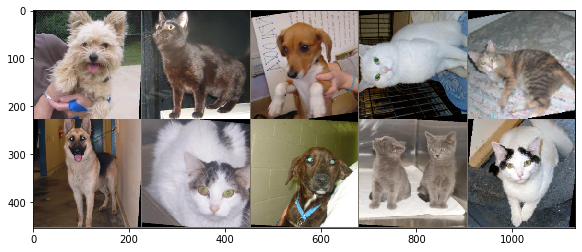

In [5]:
# Grab the first batch of 10 images (both dogs and cats with rotations and at random)
                for images,labels in train_loader: 
                    break

                # Print the labels
                print('Label:', labels.numpy())
                print('Class:', *np.array([class_names[i] for i in labels]))

                im = make_grid(images, nrow=5)  # the default nrow is 8

                # Inverse normalize the images, know from before
                inv_normalize = transforms.Normalize(
                    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                    std=[1/0.229, 1/0.224, 1/0.225]
                )
                im_inv = inv_normalize(im)

                # Print the images
                plt.figure(figsize=(12,4))
                plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

In [6]:
#define the model

class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)  # input (rgb so 3), output, filter, stride , (padding opt)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)  # can play with filters alot (depending on time) but now input needs to be output of last
        self.fc1 = nn.Linear(54*54*16, 120) #calc for 54 (dependant on pooling layer). 224-2(padding) /2 pooling layer. another conv -2 and anothe pooling /2 and 54.5 so around off to 54. 16 is # of filters from last. can also play around with 120 neurons
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2) # classes are 2 so final output is 2

    def forward(self, X):
        X = F.relu(self.conv1(X)) #rec linear conv 1
        X = F.max_pool2d(X, 2, 2) # pooling layer 2x2 with stride 2. its common
        X = F.relu(self.conv2(X)) 
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16) #now go into linear units, flatten out now. -1 cause we want to keep same batch size
        X = F.relu(self.fc1(X)) #rec linear being passed to fc
        X = F.relu(self.fc2(X))
        X = self.fc3(X)         #last one
        return F.log_softmax(X, dim=1)

In [7]:
#loss and optimization function set

torch.manual_seed(101) #101 is just random
CNNmodel = ConvolutionalNetwork() #created object and then the instance of conv network 
criterion = nn.CrossEntropyLoss() #cho0se cross entropy cause its classification
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001) #Adam optimizer, 0.001 is usually good but can play around
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [9]:
# number of parameters for CNN

for p in CNNmodel.parameters():
    print(p.numel())
    
    
#ps flattening out gives huge number of parameters 5m but rememeber with ANN would be even more

162
6
864
16
5598720
120
10080
84
168
2


In [10]:
#training

import time #to see how long training time is taking
start_time = time.time()

epochs = 3torch.save(CNNmodel.state_dict(), 'CustomImageCNNModel.pt') #set epochs

#puts a limit to num of batch only for time purposes (optional)
max_trn_batch = 800  #each batach has 10 hence 8000 here out of 18k. set variables
max_tst_batch = 300

train_losses = [] #keeping trackers
test_losses = [] 
train_correct = []
test_correct = []

for i in range(epochs): #keeping trackers
    trn_corr = 0
    tst_corr = 0
    
    # run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # limit the number of batches (optional). kinda to test your data
        if b == max_trn_batch:
            break
        b+=1
        
        # apply the model
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:  #at 200 print out following
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches while training
    with torch.no_grad(): #dont update
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches
            if b == max_tst_batch:
                break

            # Apply the model (grab predicted)
            y_val = CNNmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test) #calc loss
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/8000]  loss: 0.69422805  accuracy:  54.850%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.69677192  accuracy:  58.100%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.49043545  accuracy:  60.383%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.59264970  accuracy:  61.612%
epoch:  1  batch:  200 [  2000/8000]  loss: 0.49370328  accuracy:  68.650%
epoch:  1  batch:  400 [  4000/8000]  loss: 0.69102311  accuracy:  69.375%
epoch:  1  batch:  600 [  6000/8000]  loss: 0.73413074  accuracy:  69.667%
epoch:  1  batch:  800 [  8000/8000]  loss: 0.38021073  accuracy:  70.675%
epoch:  2  batch:  200 [  2000/8000]  loss: 0.63884568  accuracy:  74.100%
epoch:  2  batch:  400 [  4000/8000]  loss: 0.43350869  accuracy:  73.350%
epoch:  2  batch:  600 [  6000/8000]  loss: 0.61583489  accuracy:  73.017%
epoch:  2  batch:  800 [  8000/8000]  loss: 0.40551963  accuracy:  73.575%

Duration: 538 seconds


In [11]:
#always good to save the model for future since it took a lil time

torch.save(CNNmodel.state_dict(), 'CustomImageCNNModel.pt')

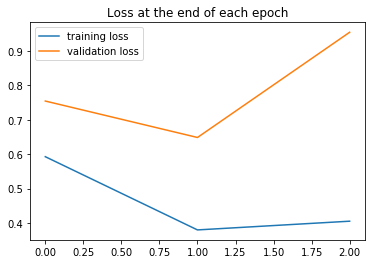

In [12]:
#evaluate model performance by plotting it

plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

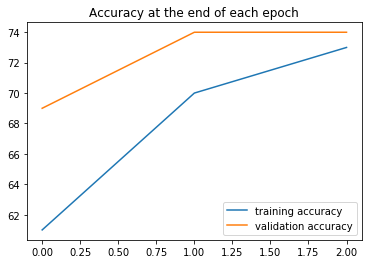

In [13]:
#evaluate at each epoch end too

plt.plot([t/80 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [14]:
#print accuracy

print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/3000:.3f}%') # last item

[tensor(2098), tensor(2224), tensor(2238)]
Test accuracy: 74.600%


In [17]:
#pretrained model example
AlexNetmodel=models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /Users/zainabusman/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 244418560/244418560 [00:23<00:00, 10257985.49it/s]


In [19]:
AlexNetmodel #check it downloaded correctly, to see the network architecture

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [20]:
# we want to freeze certain feature parameters (pretrained weights and biases)
#.grad to false to not propegate through the pretrained weights and biases

for param in AlexNetmodel.parameters():
    param.requires_grad = False



In [23]:
torch.manual_seed(42)
AlexNetmodel.classifier = nn.Sequential(nn.Linear(9216, 1024),  #first 9216 we have to keep!
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(1024, 2),
                                 nn.LogSoftmax(dim=1))
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_featur

In [24]:
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_featur

In [26]:
# These are the TRAINABLE parameters only the last few fc layers to fully leverage filter on whaag they learned from prviosu images


In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetmodel.classifier.parameters(), lr=0.001)

In [31]:
import time
start_time = time.time()

epochs = 1

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = AlexNetmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = AlexNetmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn